# part 1

In [101]:
# import Pkg
using Pkg
Pkg.add("NPZ")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [102]:
using NPZ

In [110]:
n1=400

# exponentially decaying sinusiods with different frequencies
inp = zeros(Float32,n1)
for j in n1÷15:n1÷5:n1
    wave = zeros(Float32,n1)
    for x in j:399
        y = (x-j)/400
        wave[x] = exp(-y*15)*sin(y*0.95*j)
    end
    inp += wave
end

res = similar(inp);
bak = similar(inp);
npzwrite("./npy/j_inp_base.npy",inp)

In [104]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [105]:
using Plots

function stems(data, label, color)
    "plot data using stems"
    plt=plot(zeros(Float32, n1), label=:none, color=:black)
    plot!(plt, data, line=:stem,
          label=label, color=color, legend=:outerleft,
          xlim=[0.5, n1+0.5], border=:none)
    return plt
end

stems (generic function with 1 method)

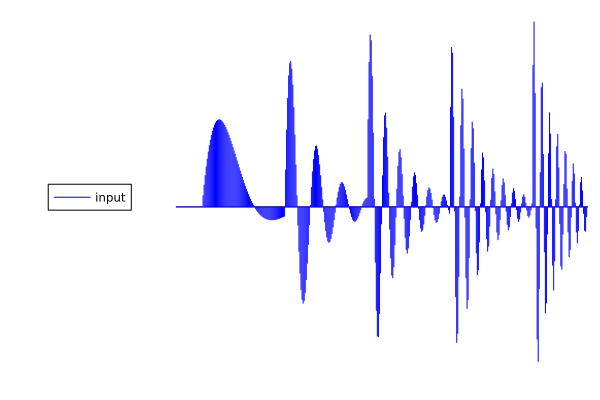

In [106]:
plot_input = stems(inp,"input",:blue)

In [149]:
function stream!(inv::Bool, d::Vector{T}, r::Vector{T}, na::Int, λ::Float32) where T <: Real
    a = zeros(T, na) # streaming PEF
    dd = da = zero(T) # d (dot) d, d (dot) a
    rn = zero(Float32)
    for ia in 1:na
        if (inv)
            d[ia] = r[ia]
        else
            r[ia] = d[ia]
        end
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (inv) # from r to d
            rn = r[i1] / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else     # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
            if i1 == 33
                println("{i1=}",i1)
                println("{dn=}",dn)
                println("{da=}",da)
                println("{dd=}",dd)
                println("{rn=}",rn)
                println(typeof(rn))
                println(typeof(dn))
                println(typeof(da))
                println(typeof(dd))
                println(typeof(λ))
            end
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-ia]
            # if i1 == 33
            #     println("{i1=}",i1)
            #     println("{ia=}",ia)
            #     println("{dn=}",dn)
            #     println("{da=}",da)
            #     println("{dd=}",dd)
            #     println("{d[i1-ia]=}",d[i1-ia])
            #     println("{rn=}",rn)
            #     println(typeof(rn))
            #     println(typeof(dn))
            #     println(typeof(da))
            #     println(typeof(dd))
            #     println("{a[ia]=}",a[ia])
            #     println("{rn * d[i1-ia]=}",rn * d[i1-ia])
            #     println("\n\n")
            # end
        end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]
        da = dn * a[1]
        for ia in 2:na; da += a[ia] * d[i1-ia+1]; end
    end
end

stream! (generic function with 2 methods)

In [150]:
stream!(false, inp, res, 2, 0.1)
npzwrite("./npy/j_inp.npy",inp)
npzwrite("./npy/j_res.npy",res)
plot_decon = stems(res, "decon", :green);

{i1=}33
{dn=}0.3221985
{da=}-0.29552683
{dd=}0.14705636
{rn=}0.10795786941832876
Float64
Float32
Float32
Float32
Float64


In [109]:
stream!(true, bak, res, 2, 0.1)
plot_inverse = stems(bak,"inverse",:purple);

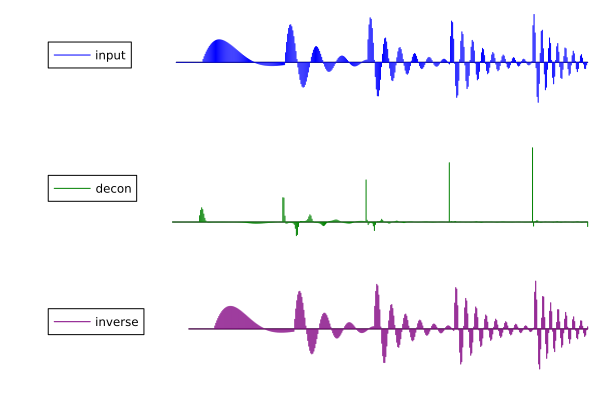

In [57]:
plot(plot_input, plot_decon, plot_inverse, layout=(3, 1))

In [58]:
# savefig("stream.pdf")

### Multiple dimensions

In [59]:
inp2 = deepcopy(inp)
known = ones(Bool,n1)

# Cut holes in the data and create a mask
for hole in (55, 153, 246, 301, 376)
    inp2[hole:hole+20] .= 0
    known[hole:hole+20] .= false
end

In [60]:
function stream_missing!(d::Vector{T}, k::Vector{Bool}, na::Int, λ::Real) where T <: Real
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (k[i1]) # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
        else       # assume r=0
            dn = - da
            rn = zero(T)
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-ia]
        end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1-ia+1]
        end
    end
end

stream_missing! (generic function with 1 method)

In [61]:
plot_ideal = stems(inp,"ideal ",:blue);
plot_hole = stems(inp2,"input ",:green);

In [62]:
miss = deepcopy(inp2)
stream_missing!(miss,known,2,0.05)

In [63]:
plot_interp = stems(miss,"filled",:purple);

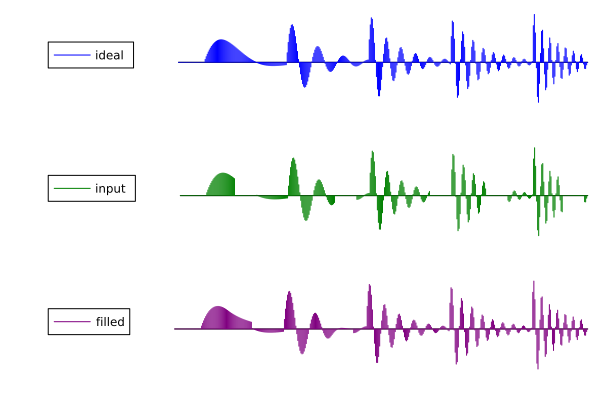

In [64]:
plot(plot_ideal, plot_hole, plot_interp, layout=(3, 1))

In [65]:
# savefig("mstream.pdf")

# part 2

In [66]:
import Pkg; Pkg.add("ZipFile")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [67]:
using ZipFile

# download data from a public server
download("https://zenodo.org/api/records/11099632/files-archive", "files.zip")
# unzip the archive file
r = ZipFile.Reader("files.zip")

ZipFile.Reader for IOStream(<file files.zip>) containing 3 files:

uncompressedsize method  mtime            name
----------------------------------------------
          125000 Store   2024-10-04 09-17 seis.rsf@
           65536 Store   2024-10-04 09-17 wood.rsf@
           65536 Store   2024-10-04 09-17 herr.rsf@


In [68]:
# make a dictionary of files for easy access
patterns = Dict{String, IO}()
for file in r.files
    name = splitext(file.name)[1]
    patterns[name] = file
end

In [69]:
# download "wood" pattern
wood = Array{Float32}(undef, 128, 128) # single-precision array
read!(patterns["wood"], wood)
npzwrite("./npy/j_wood.npy")

┌ Warning: no data to be written to ./npy/j_wood.npy. It might not be possible to read the file correctly.
└ @ NPZ /home/gitpod/.julia/packages/NPZ/UCofn/src/NPZ.jl:432


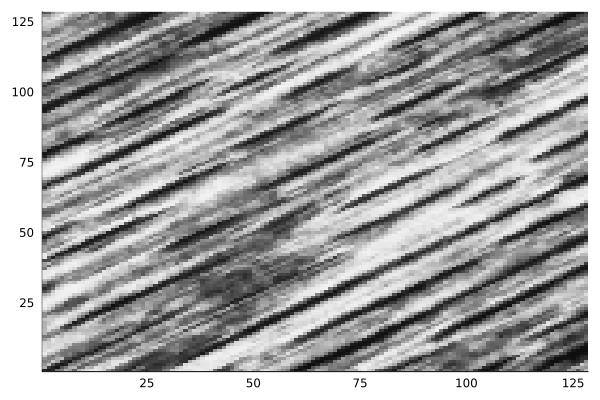

In [70]:
heatmap(wood,legend=:none,color=:grays)

In [71]:
function punch_hole(data::Matrix{T}) where T <: Real
    # make an elliptical hole
    n1, n2 = size(data)
    hole = similar(data)
    mask = zeros(Bool, n1, n2)
    for i2 in 1:n2, i1 in 1:n1
        x = (i1-1)/n1 - 0.5
        y = (i2-1)/n2 - 0.3
        u =  x + y
        v = (x - y)/2
        if (u*u + v*v < 0.15)
            hole[i1,i2] = zero(T)
        else
            hole[i1,i2] = data[i1,i2]
            mask[i1,i2] = true
        end
    end
    return hole, mask
end

whole, wmask = punch_hole(wood);
npzwrite("./npy/j_whole.npy", whole)
npzwrite("./npy/j_wmask.npy", wmask)

In [72]:
function helix(lag::Vector{Tuple{T, T}}, ci::CartesianIndices) where T <: Integer
    "convert filter lags to helix lags for a given grid"
    # middle of the grid
    mid = CartesianIndex(Tuple(last(ci)) .÷ 2)
    # helix index of middle
    hmid = LinearIndices(ci)[mid]
    # from Cartesian shift to helix shift
    return LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] .- hmid
end

helix (generic function with 1 method)

In [73]:
import Random

function stream_missing_helix!(d, k,
                               lag::Vector{Tuple{I, I}},
                               λ::Real, std=0, seed=1) where I <: Integer
    "Fill missing data in multiple dimensions using streaming PEF on a helix"
    println(d[2560:2560+10])
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))

    npzwrite("./npy/j_hlag.npy",hlag)
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d

    for ia in 1:na
        dd += d[maxlag+1-hlag[ia]]^2
    end
    sumrn = 0
    i= 0 
    Random.seed!(seed)
    for i1 in maxlag+1:n1
        if (k[i1])
            i+=1
            dn = d[i1]
            if i <= 4
                println(i1)
                println(dn)
            end
            rn = (dn + da) / (λ + dd)
            sumrn += rn
        else # assume r_n is random
            # myrandom = randn()
            myrandom = 0.26
            rn = std * myrandom / λ

            sumrn += rn
            dn = rn * (λ + dd) - da
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
    println("sumrn : ", sumrn)
end

stream_missing_helix! (generic function with 3 methods)

In [74]:
# 11 x 11 PEF
lag=[(x,0) for x in 1:5]
for k in 1:10
    lag = vcat(lag,[(x,k) for x in -5:5])
end

In [75]:
function fill_hole(forward::Bool, hole, mask, pad::Integer, noise=0, seed=1)
    if forward
        holepad = hcat(zeros(Float32, size(hole, 1), pad), hole)
        npzwrite("./npy/j_holepad.npy", holepad)
        npzwrite("./npy/j_hole.npy", hole)
        maskpad = hcat(zeros(Bool, size(hole, 1), pad), mask)
        # npzwrite("./npy/j_maskpad.npy", maskpad)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed)
        return holepad[:,pad+1:end]
    else
        rhole = reverse(hole)
        # npzwrite("./npy/j_else_rhole.npy",rhole)

        rmask = reverse(mask)
        # npzwrite("./npy/j_else_rmask.npy",rmask)
        holepad = hcat(zeros(Float32, size(rhole, 1), pad), rhole)
        npzwrite("./npy/j_else_holepad.npy",holepad)
        maskpad = hcat(zeros(Bool, size(rhole, 1), pad), rmask)
        npzwrite("./npy/j_else_maskpad.npy",maskpad)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed+1)
        return reverse(holepad[:,pad+1:end])
    end
end

fill_hole (generic function with 3 methods)

In [76]:
npzwrite("./npy/j_whole_before.npy", whole)
filled1 = fill_hole(true, whole, wmask, 20);
npzwrite("./npy/j_filled1.npy",filled1)
filled2 = fill_hole(false, whole, wmask, 20);
npzwrite("./npy/j_filled2.npy",filled2)

Float32[0.0, -122.865295, 32.134705, 6.1347046, -18.865295, 2.1347046, 69.134705, 100.134705, 85.134705, 82.134705, 75.134705]
2561
-122.865295
2562
32.134705
2563
6.1347046
2564
-18.865295
sumrn : 0.0028180676221277534
Float32[0.0, -92.865295, -66.865295, -48.865295, -45.865295, 3.1347046, -12.865295, -43.865295, -70.865295, -45.865295, -3.8652954]
2561
-92.865295
2562
-66.865295
2563
-48.865295
2564
-45.865295
sumrn : -0.0002814470734843825


In [77]:
plot2(data, title) = heatmap(data, yflip=:true, clim=(-137, 137),
                             legend=:none, color=:grays, title=title)

plot2 (generic function with 1 method)

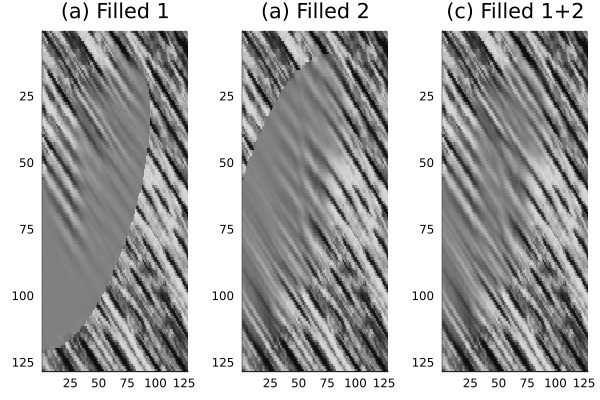

In [78]:
p1 = plot2(filled1, "(a) Filled 1")
p2 = plot2(filled2, "(a) Filled 2")
p3 = plot2(filled1 + filled2 - whole, "(c) Filled 1+2")

npzwrite("./npy/j_p3.npy",filled1+filled2-whole)
plot(p1, p2, p3, layout=(1, 3))

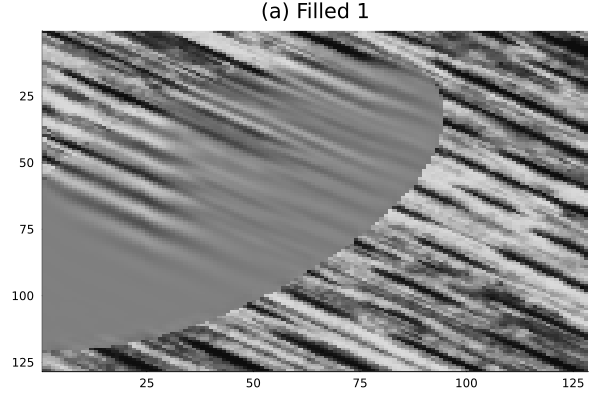

In [79]:
p1 = plot2(filled1, "(a) Filled 1")

In [80]:
# savefig("interp.pdf")

Float32[0.0, -122.865295, 32.134705, 6.1347046, -18.865295, 2.1347046, 69.134705, 100.134705, 85.134705, 82.134705, 75.134705]
2561
-122.865295
2562
32.134705
2563
6.1347046
2564
-18.865295
sumrn : NaN
Float32[0.0, -92.865295, -66.865295, -48.865295, -45.865295, 3.1347046, -12.865295, -43.865295, -70.865295, -45.865295, -3.8652954]
2561
-92.865295
2562
-66.865295
2563
-48.865295
2564
-45.865295
sumrn : NaN


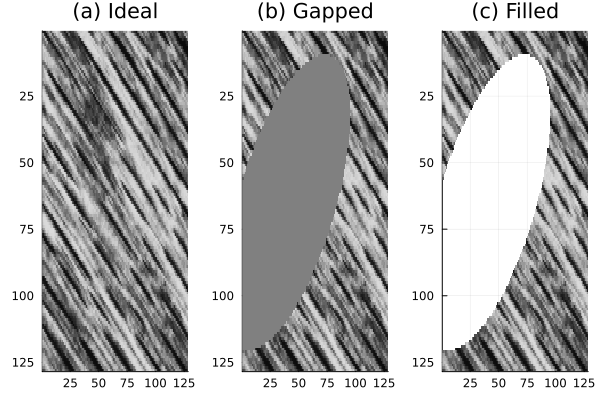

In [81]:
filled = fill_hole(true,  whole, wmask, 20, 2) +
         fill_hole(false, whole, wmask, 20, 2) - whole

p1 = plot2(wood, "(a) Ideal")
p2 = plot2(whole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [82]:
# savefig("wood-hole.pdf")

Float32[0.0, -122.865295, 32.134705, 6.1347046, -18.865295, 2.1347046, 69.134705, 100.134705, 85.134705, 82.134705, 75.134705]
2561
-122.865295
2562
32.134705
2563
6.1347046
2564
-18.865295
sumrn : NaN
Float32[0.0, -92.865295, -66.865295, -48.865295, -45.865295, 3.1347046, -12.865295, -43.865295, -70.865295, -45.865295, -3.8652954]
2561
-92.865295
2562
-66.865295
2563
-48.865295
2564
-45.865295
sumrn : NaN
Float32[0.0, -122.865295, 32.134705, 6.1347046, -18.865295, 2.1347046, 69.134705, 100.134705, 85.134705, 82.134705, 75.134705]
2561
-122.865295
2562
32.134705
2563
6.1347046
2564
-18.865295
sumrn : NaN
Float32[0.0, -92.865295, -66.865295, -48.865295, -45.865295, 3.1347046, -12.865295, -43.865295, -70.865295, -45.865295, -3.8652954]
2561
-92.865295
2562
-66.865295
2563
-48.865295
2564
-45.865295
sumrn : NaN
Float32[0.0, -122.865295, 32.134705, 6.1347046, -18.865295, 2.1347046, 69.134705, 100.134705, 85.134705, 82.134705, 75.134705]
2561
-122.865295
2562
32.134705
2563
6.1347046
2564
-

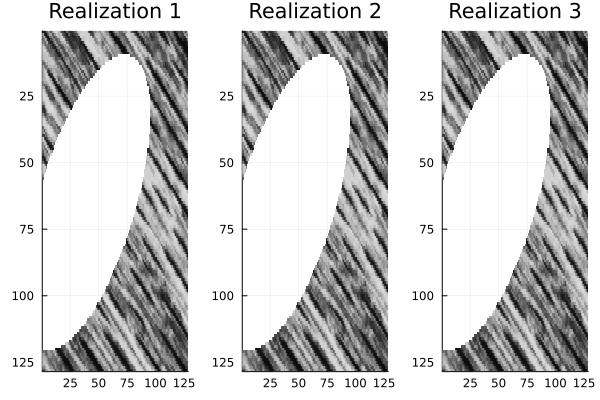

In [83]:
p = Array{Plots.Plot}(undef,3)
for k in 1:3
    filled = fill_hole(true,  whole, wmask, 20, 2, k) +
             fill_hole(false, whole, wmask, 20, 2, k+3) - whole
    p[k] = plot2(filled, "Realization $k")
end
plot(p[1], p[2], p[3], layout=(1, 3))

In [84]:
# savefig("realiz.pdf")

In [85]:
# "herring" pattern
herr = Array{Float32}(undef, 128, 128) # single-precision array
# read data
read!(patterns["herr"], herr)
npzwrite("./npy/j_herr.npy",herr)
# make a hole
hhole, hmask = punch_hole(herr);
npzwrite("./npy/j_hhole.npy",hhole)
npzwrite("./npy/j_hmask.npy",hmask)

Float32[0.0, -58.72046, 24.279541, 108.27954, 71.27954, -34.72046, -86.72046, -65.72046, -42.72046, 38.27954, 113.27954]
2561
-58.72046
2562
24.279541
2563
108.27954
2564
71.27954
sumrn : NaN
Float32[0.0, -34.72046, -25.720459, -30.720459, 37.27954, 57.27954, -67.72046, -65.72046, -64.72046, 36.27954, 77.27954]
2561
-34.72046
2562
-25.720459
2563
-30.720459
2564
37.27954
sumrn : NaN


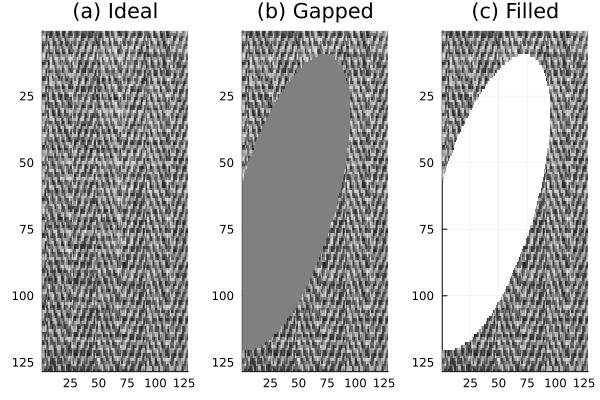

In [86]:
filled = fill_hole(true,  hhole, hmask, 20, 6) +
         fill_hole(false, hhole, hmask, 20, 6) - hhole

p1 = plot2(herr, "(a) Ideal")
p2 = plot2(hhole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [87]:
# savefig("herr-hole.pdf")

In [88]:
# "seismic" pattern
seis = Array{Float32}(undef, 250, 125) # single-precision array
# read data
read!(patterns["seis"], seis)
npzwrite("./npy/j_seis_base.npy", seis)


In [89]:
using Statistics

# normalize
m = mean(seis)
seis .-= m
scale = std(wood)/std(seis)
seis *= scale


npzwrite("./npy/j_seis.npy", seis)

# make a hole
shole, smask = punch_hole(seis);
npzwrite("./npy/j_shole.npy", shole)
npzwrite("./npy/j_smask.npy", smask)

Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5001
2.255681
5002
2.255681
5003
2.255681
5004
2.255681
sumrn : 0.0015572145059369225
Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5001
53.527252
5002
5.2626996
5003
-76.87839
5004
-32.039555
sumrn : 0.0020258802360701204


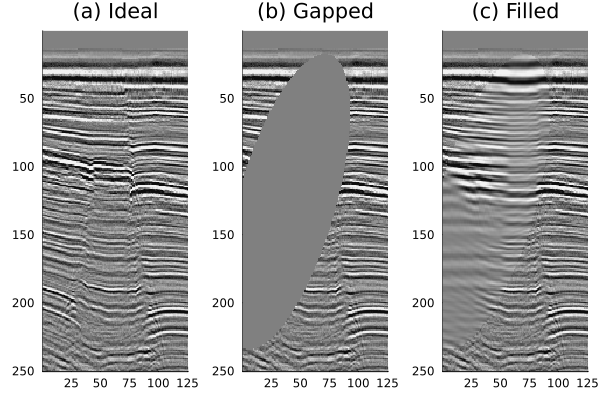

In [90]:
filled = fill_hole(true,  shole, smask, 20, 0.7) +
         fill_hole(false, shole, smask, 20, 0.7) - shole

p1 = plot2(seis, "(a) Ideal")
p2 = plot2(shole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [91]:
# savefig("WGstack-hole.pdf")

In [92]:
function stream_helix!(inv::Bool, d, r, lag::Vector{Tuple{I, I}}, λ::Real) where I <: Integer
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    for i1 in 1:maxlag
        if (inv)
            d[i1] = r[i1]
        else
            r[i1] = d[i1]
        end
    end
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[maxlag+1-hlag[ia]]^2
    end
    for i1 in maxlag+1:n1
        if (inv)
            rn = r[i1] / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
end

stream_helix! (generic function with 1 method)

In [93]:
# apply helix filter
pad = hcat(zeros(Float32, size(seis, 1), 20), seis)
res= similar(pad)
stream_helix!(false, pad, res, lag, 1e6) # pad -> res
stream_helix!(true,  pad, res, lag, 1e6) # pad <- res

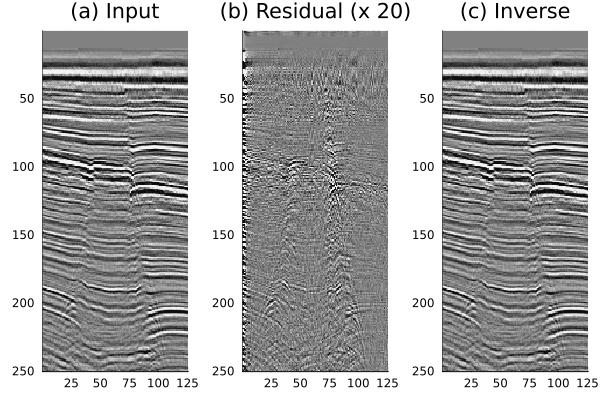

In [94]:
p1 = plot2(seis, "(a) Input")
p2 = plot2(20*res[:,21:end], "(b) Residual (x 20)")
p3 = plot2(pad[:,21:end], "(c) Inverse")
plot(p1, p2, p3, layout=(1, 3))

# TMP ZONE